In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas
import pdb, traceback, sys
import scipy
from scipy import signal
import datetime

# Imports useful for graphics
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# Give you access to all the V2G-Sim modules
import h2vgi

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Create a project that will hold other objects such as vehicles, locations
# car models, charging stations and some results. (see model.Project class)
project = h2vgi.model.Project()

# Use the itinerary module to import itineraries from an Excel file.
# Instantiate a project with the necessary information to run a simulation.
# Default values are assumed for the vehicle to model
# and the charging infrastructures to simulate.
project = h2vgi.itinerary.from_excel(project, '../data/NHTS/Tennessee.xlsx')
project = h2vgi.itinerary.copy_append(project, nb_of_days_to_add=7)

for vehicle in project.vehicles:
    vehicle.result_function = h2vgi.result.save_vehicle_power_demand

# Launch the simulation and save the results
h2vgi.core.run(project, date_from=project.date, date_to=project.date +  datetime.timedelta(days=7))

itinerary.from_excel(project, ../data/NHTS/Tennessee.xlsx)
Loading ...


core.run: 100%|###############################################################|


In [1]:
# total cumsumption
total_consumption = project.locations[0].result
for location in project.locations[1:]:
    total_consumption += location.result

NameError: name 'project' is not defined

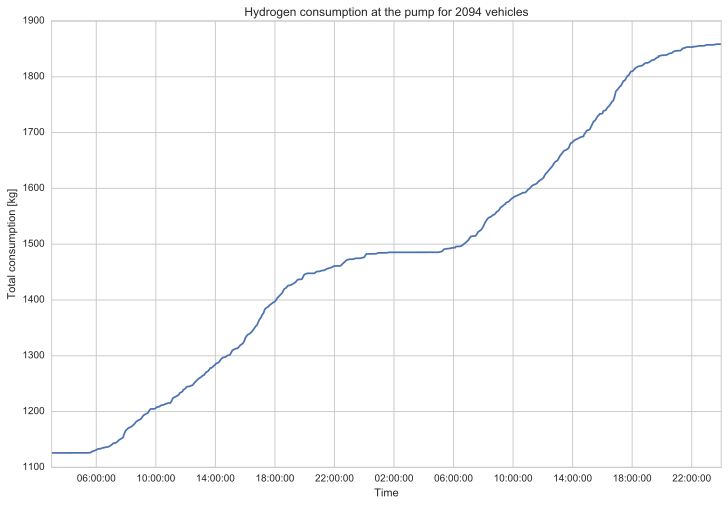

In [4]:
plt.figure(figsize=(12, 8), dpi=60)
plt.plot(total_consumption.power_demand.cumsum().tail(2700) * 60)
plt.title('Hydrogen consumption at the pump for ' + str(len(project.vehicles)) + ' vehicles')
plt.ylabel('Total consumption [kg]')
plt.xlabel('Time')
plt.show()

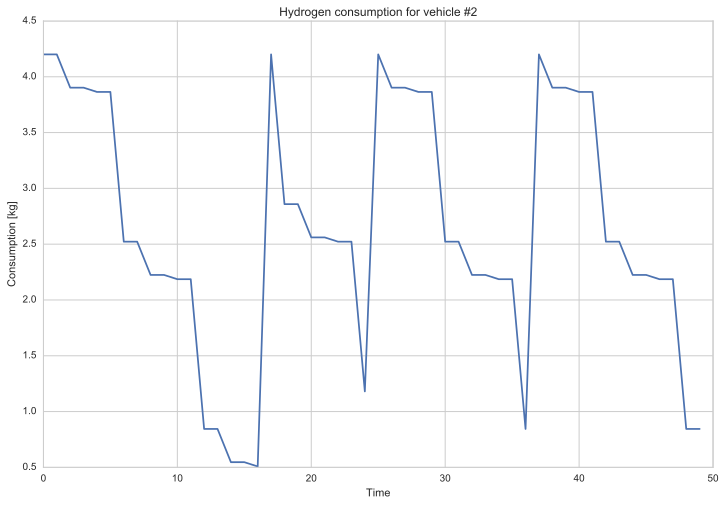

In [5]:
index = 2

plt.figure(figsize=(12, 8), dpi=60)
plt.plot(project.vehicles[index].hydrogen)
plt.title('Hydrogen consumption for vehicle #' + str(index))
plt.ylabel('Consumption [kg]')
plt.xlabel('Time')
plt.show()

In [6]:
tot_distance = 0
tot_trip = 0
for activity in project.vehicles[index].activities:
    if isinstance(activity, h2vgi.model.Driving):
        tot_distance += activity.distance
        tot_trip += 1
        
print('total distance : ' + str(tot_distance) + ' km')
print('number of trips in seven days : ' + str(tot_trip) + ' trips')

total distance : 772.4832 km
number of trips in seven days : 24 trips


In [7]:
def gausse_moving_average_filter(array, window):
    """Moving average filter with gaussian coeficient.
    Args:
        array: list of values
        window: moving average window 
    Returns:
        - filtered array
    Example:
        >>> filteredArray = gausse_moving_average_filter(array, window)
    """

    coef = signal.gaussian(window, 10)
    return scipy.ndimage.filters.convolve1d(array, coef/sum(coef))

In [8]:
demand = pandas.DataFrame()
first = True
for vehicle in project.vehicles:
    if first:
        demand['power'] = vehicle.result['power_demand']
        first = False
    else:
        demand['power'] += vehicle.result['power_demand']
demand['energy'] =  demand.power.cumsum() * 60
demand['smooth_power'] = gausse_moving_average_filter(demand['power'], 10)

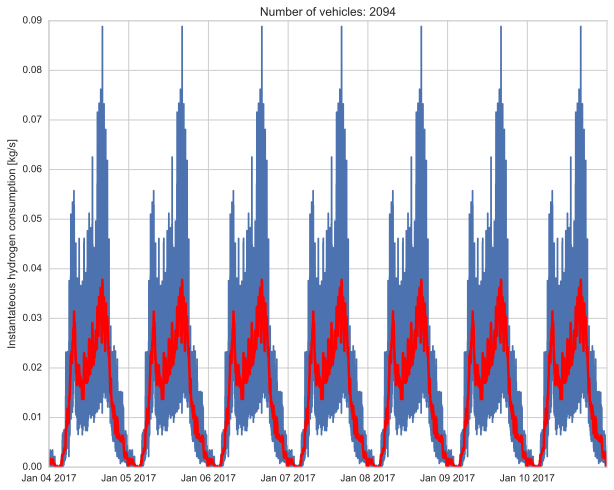

In [9]:
plt.figure(figsize=(10, 8), dpi=60)
plt.plot(demand['power'])
plt.plot(demand['smooth_power'], color='red', linewidth=2.5)
plt.title('Number of vehicles: ' + str(len(project.vehicles)))
plt.ylabel('Instantateous hydrogen consumption [kg/s]')
plt.show()

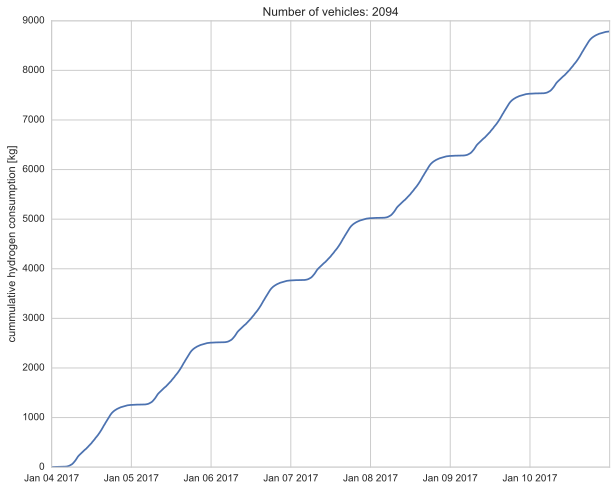

In [10]:
plt.figure(figsize=(10, 8), dpi=60)
plt.plot(demand['energy'])
plt.title('Number of vehicles: ' + str(len(project.vehicles)))
plt.ylabel('cummulative hydrogen consumption [kg]')
plt.show()

In [11]:
def filter(vehicle):
    # Sum up the total distance traveled per day
    distance = 0
    for activity in vehicle.activities:
        if isinstance(activity, h2vgi.model.Driving):
            distance += activity.distance
    
    # True vehicle is accounted for
    if distance > 100:
        return False
    else:
        return True

In [12]:
# Find the distribution of hydrogen usage
daily_hydrogen = []
count = 0
for vehicle in project.vehicles:
    if filter(vehicle):
#     if True:
        count += 1
        daily_hydrogen.append(vehicle.result['power_demand'].cumsum().tail(1).values[0] * 60)

Average consumption is 0.218342503823 kg


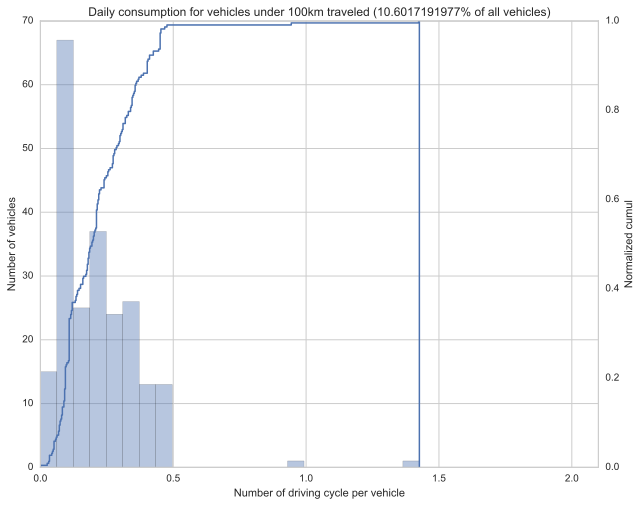

In [13]:
plt.figure(figsize=(10, 8), dpi=60)

_ = seaborn.distplot(daily_hydrogen, kde=False)

ax = plt.gca()
ax2 = ax.twinx()
ax2.grid(b=False)
_ = ax2.hist(daily_hydrogen, 500, normed=True, histtype='step', cumulative=True, linewidth=1.5)
plt.xlim([0, 2.1])

ax.set_ylabel('Number of vehicles')
ax2.set_ylabel('Normalized cumul')
ax.set_xlabel('Number of driving cycle per vehicle')
plt.title('Daily consumption for vehicles under 100km traveled (' + str(count * 100 / len(project.vehicles)) + '% of all vehicles)')

print('Average consumption is ' + str(sum(daily_hydrogen) / len(daily_hydrogen)) + ' kg')
plt.show()

In [14]:
# Find the distribution of hydrogen usage
daily_hydrogen2 = []
count2 = 0
for vehicle in project.vehicles:
    if not filter(vehicle):
        count2 += 1
        daily_hydrogen2.append(vehicle.result['power_demand'].cumsum().tail(1).values[0] * 60)

In [15]:
print(str(round(count * 100 / len(project.vehicles), 2)) + '% of all vehicles drive less than 100km and represent ' +
      str(round(sum(daily_hydrogen) * 100 / (sum(daily_hydrogen2) + sum(daily_hydrogen)), 2)) + '% of the consumption.')

10.6% of all vehicles drive less than 100km and represent 0.55% of the consumption.


In [16]:
# Find the distribution of hydrogen usage
daily_hydrogen3 = []
for vehicle in project.vehicles:
    if True:
        daily_hydrogen3.append(vehicle.result['power_demand'].cumsum().tail(1).values[0] * 60)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


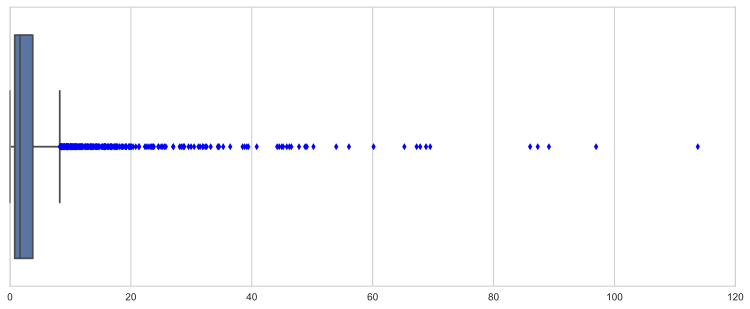

In [17]:
plt.figure(figsize=(13, 5), dpi=60)
ax = seaborn.boxplot(daily_hydrogen3)